
# Tutorial: Frequency Domain Visualization



#### Brain Computer Interfaces (BCIs)
Brain-computer interfaces (BCIs) provide a direct pathway between the human brain and an external device, and can be especially useful for people with severe disabilities. A BCI can bypass the damaged pathways in order to provide the user with the ability to communicate or interact effectively with their surroundings. BCIs provide novel possibilities for neurorehabilitation for people with neurological disease such as stroke, amyotrophic lateral sclerosis (ALS) or paralysis.

There are two types of BCIs: endogenous and exogenous BCIs. Endogenous BCIs allows the user to voluntarily modulate
his/her neuronal activity based on intention. For example: Motor Imagery (MI BCI) – the user imagines a motor
movement such as moving the right hand/left hand or imagines lifting up the ankle (ankle
dorsiflexion). Exogenous BCIs are based on responses elicited due to an external stimulus. These responses are generated when the user focuses his/her attention on a stimulus which is associated with a BCI command. Examples include P300 BCI, steady-state visual evoked potentials (SSVEP) based BCIs, steady-state motion visual evoked potential (SSMVEP) BCIs, etc. 


#### Steady-state Visual evoked Potentials (SSVEP) based BCI

Steady-state visual evoked potentials are responses elicited when a user focuses his/her attention on a repetitive visual stimulus (a light source) flickering at frequencies higher than 6 Hz. These are periodic responses prominently observed in the occipital and occipito-parietal areas of the cortex. SSVEP responses appear as an increase in the amplitude of the signal at the fundamental frequency and its harmonics for the corresponding stimulus attended by the user. Therefore, by analyzing the dominant frequency response in the EEG, the stimulus attended to by the user can be identified. 



#### In this tutorial, we will be looking into a 12-class SSVEP dataset and plot these responses in the EEG.

<img src="12_classSSVEP.png">

In this example, there are 12 SSVEP stimuli flashing at the corresponsing flicker frequencies. The user gazes at one of the flickering targets in random order for 4 seconds. In this way 15 trials are recorded from 8 EEG channels. For more details please refer to the paper.



#### Dataset URL: 
https://github.com/mnakanishi/12JFPM_SSVEP/tree/master/data

#### Dataset Paper:
Masaki Nakanishi, Yijun Wang, Yu-Te Wang and Tzyy-Ping Jung, 
"A Comparison Study of Canonical Correlation Analysis Based Methods for Detecting Steady-State Visual Evoked Potentials," 
PLoS One, vol.10, no.10, e140703, 2015. 

#### Implementation:
Note: Following implementation plots the frequency response of each flicker frequency across all trials on channel Oz. To visualize each flicker frequency's response, in this code, we average across all trials. 




In [1]:
import sys
import os
sys.path.insert(0, os.path.abspath('..'))

In [2]:
%%capture
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import scipy.io as sio
import time

import math
import warnings
warnings.filterwarnings('ignore')

import numpy as np
from scipy.signal import butter, filtfilt
import time
from  utils import *

In [3]:
def plot_spectrum(ax, magnitude_spectrum, resolution, num_classes, subject, channel, flicker_freq):
    for target in range(num_classes):
        fft_axis = np.arange(magnitude_spectrum.shape[0])*resolution
        ax[target].plot(fft_axis, np.mean(np.squeeze(magnitude_spectrum[:, channel, target, :, :]), 
                                          axis=1))
        ax[target].set_xlabel('Frequency (Hz)') 
        ax[target].set_ylabel('Amplitude (uV)')
        ax[target].set_title(f'Subject {subject} stimulus frequency {flicker_freq[target]} Hz')
    plt.show()

Fill in the missing values from the provided paper.

In [4]:

data_path = r"C:\Users\lenovo\Desktop\bci\data"
magnitude_spectrum = dict()
window_len = 4
shift_len = 4
sample_rate = 256
flicker_freq = np.array([9.25, 11.25, 13.25, 9.75, 11.75, 13.75, 
                       10.25, 12.25, 14.25, 10.75, 12.75, 14.75])

Using Scipy Library Design a BPF Function which has the following arguments "data, lowcut, highcut, sample_rate, and  order"
You can google it.

In [5]:
def bandpass_filter(data, lowcut, highcut, sample_rate, order):
    '''
    Returns bandpass filtered data between the frequency ranges specified in the input.

    Args:
        data (numpy.ndarray): array of samples. 
        lowcut (float): lower cutoff frequency (Hz).
        highcut (float): lower cutoff frequency (Hz).
        sample_rate (float): sampling rate (Hz).
        order (int): order of the bandpass filter.

    Returns:
        (numpy.ndarray): bandpass filtered data.
    '''
    
    b, a = butter(order, [lowcut, highcut], btype='band',fs=sample_rate)
    y = filtfilt(b, a, data)


    return y

def get_filtered_eeg(eeg, lowcut, highcut, order, sample_rate):
    '''
    Returns bandpass filtered eeg for all channels and trials.

    Args:
        eeg (numpy.ndarray): raw eeg data of shape (num_classes, num_channels, num_samples, num_trials).
        lowcut (float): lower cutoff frequency (Hz).
        highcut (float): lower cutoff frequency (Hz).
        order (int): order of the bandpass filter.
        sample_rate (float): sampling rate (Hz).

    Returns:
        (numpy.ndarray): bandpass filtered eeg of shape (num_classes, num_channels, num_samples, num_trials).
    '''
    
    num_classes = 12
    num_chan =  8
    total_trial_len = 4 * 256 
    num_trials = 15
    
    trial_len = int(0.135*sample_rate+4*sample_rate-1) - int(0.135*sample_rate)
    filtered_data = np.zeros((eeg.shape[0], eeg.shape[1], trial_len, eeg.shape[3]))
  

    for target in range(num_classes):
        for channel in range(num_chan):
            for trial in range(num_trials):
                signal_to_filter = np.squeeze(eeg[target, channel, int(0.135*sample_rate) : int(0.135*sample_rate+4*sample_rate-1), trial])
                
                filtered_data[target, channel, :, trial] = bandpass_filter(signal_to_filter, lowcut, 
                                                                                  highcut, sample_rate, order)
    return filtered_data


In [6]:

def get_segmented_epochs(data, window_len, shift_len, sample_rate):
    '''
    Returns epoched eeg data based on the window duration and step size.

    Args:
        data (numpy.ndarray): array of samples. 
        window_len (int): window length (seconds).
        shift_len (int): step size (seconds).
        sample_rate (float): sampling rate (Hz).

    Returns:
        (numpy.ndarray): epoched eeg data of shape. 
        (num_classes, num_channels, num_trials, number_of_segments, duration).
    '''
    
    num_classes = 12
    num_chan = 8 
    num_trials = 15
    
    duration = 4
    data_overlap = 0
    
    number_of_segments = int(math.ceil((data.shape[2] - data_overlap)/
                                       (duration - data_overlap)))
    
    segmented_data = np.zeros((data.shape[0], data.shape[1], 
                               data.shape[3], number_of_segments, duration))

    for target in range(num_classes):
        for channel in range(num_chan):
            for trial in range(num_trials):
                segmented_data[target, channel, trial, :, :] = buffer(data[target, channel, :, trial], 
                                                                      duration, data_overlap) 
    
    return segmented_data

# Load the Data Set
Load the dataset and compute the magnitude spectrum for every trial. Method "shape" returns size of a given numpy array.

In [7]:
# data_path=""
for subject in np.arange(0, 10):
    dataset = sio.loadmat(f'{data_path}/s{subject+1}.mat')
    eeg = np.array(dataset['eeg'], dtype='float32')

    
    num_classes = 12
    n_ch = 8
    total_trial_len = 4 * 256
    num_trials = 15
    
    filtered_data = get_filtered_eeg(eeg, 6, 80, 4, sample_rate)
    
    segmented_data = get_segmented_epochs(filtered_data, window_len, shift_len, sample_rate)
    magnitude_spectrum[f's{subject+1}'] = magnitude_spectrum_features(segmented_data)

# Frequency Response calculated using Fast-Fourier Transform (FFT)

## Subject 8
Example dataset containing good frequency responses for each flicker frequency.
The flicker frequencies can be readily identified from the magnitude response of the signal.

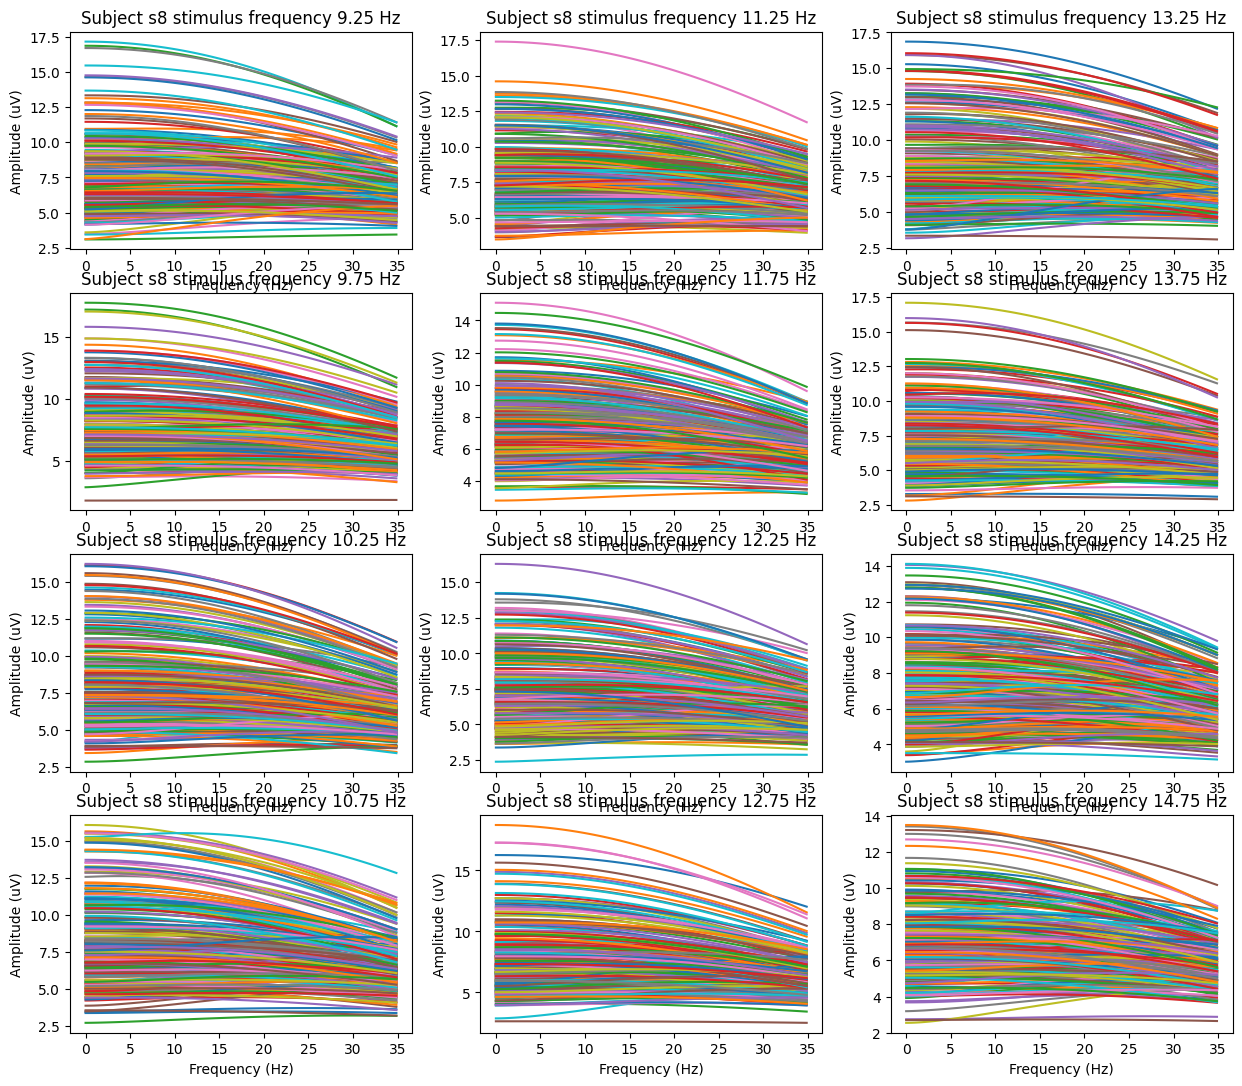

In [9]:
FFT_PARAMS = {
'resolution': 0.2930,
'start_frequency': 0.0,
'end_frequency': 35.0,
'sampling_rate': 256}

subject = 's8'
channel = 7
fig, axes = plt.subplots(4, 3, figsize=(15, 13))
axes = axes.reshape(-1)
plot_spectrum(axes, magnitude_spectrum[subject], FFT_PARAMS['resolution'], num_classes, 
              subject, channel, flicker_freq)

## Subject 2
Example dataset containing bad/noisy frequency response for each flicker frequency.
In this case, the flicker frequencies are not easily distinguishable from one another based on the frequency response.

#### Note: These responses are calculated for the signal duration of 4 s. The responses can vary if the signal duration was reduced.
#### This inter-subject variability can also be observed in the next section on Canonical Correlation Analysis (CCA) based classification of SSVEP responses.




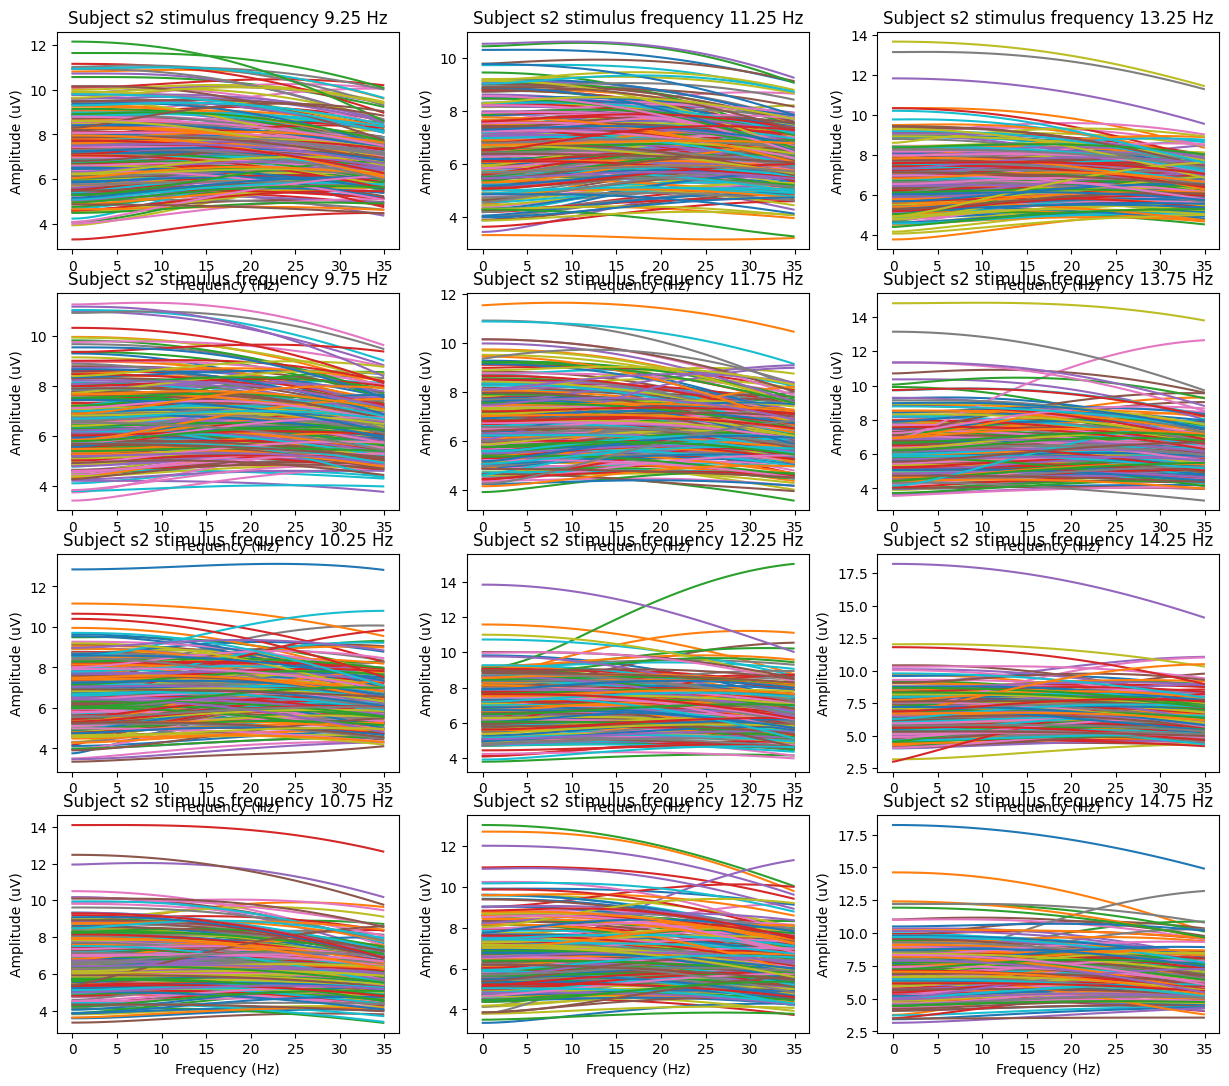

In [10]:
FFT_PARAMS = {
'resolution': 0.2930,
'start_frequency': 0.0,
'end_frequency': 35.0,
'sampling_rate': 256}

subject = 's2'
channel = 1
fig, axes = plt.subplots(4, 3, figsize=(15, 13))
axes = axes.reshape(-1)
plot_spectrum(axes, magnitude_spectrum[subject], FFT_PARAMS['resolution'], num_classes, 
              subject, channel, flicker_freq)